#### 1. Data Loading & Merging

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer

# Load all datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert date fields to datetime
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

# Merge all datasets
merged_data = pd.merge(
    pd.merge(transactions, customers, on='CustomerID'),
    products, on='ProductID'
)

#### 2. Feature Engineering

In [46]:
def create_customer_features(df):
    # Create comprehensive customer features
    features = df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'TransactionDate': ['min', 'max'],
        'Region': 'first',
        'SignupDate': 'first'
    })
    
    # Flatten multi-index columns
    features.columns = [
        'total_spent', 'avg_transaction', 'transaction_count',
        'first_purchase', 'last_purchase', 'region', 'signup_date'
    ]
    
    # Calculate derived features
    reference_date = pd.to_datetime('2024-12-31')
    features['days_since_signup'] = (reference_date - features['signup_date']).dt.days
    features['days_since_last_purchase'] = (reference_date - features['last_purchase']).dt.days
    
    # Determine favorite product category
    category_counts = df.groupby(['CustomerID', 'Category'])['TransactionID'].count().unstack().fillna(0)
    features['favorite_category'] = category_counts.idxmax(axis=1)
    
    return features

customer_features = create_customer_features(merged_data)

#### 3. Encoding & Normalization

In [48]:
# Define feature types
numerical_features = [
    'total_spent', 'avg_transaction', 'transaction_count',
    'days_since_signup', 'days_since_last_purchase'
]
categorical_features = ['region', 'favorite_category']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Transform features
X = preprocessor.fit_transform(customer_features)

#### 4. Similarity Calculation

In [50]:
# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Convert to DataFrame with customer IDs
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=customer_features.index,
    columns=customer_features.index
)

#### 5. Top-N Recommendations

In [53]:
def get_top_similar_customers(target_customer, similarity_df, n=3):
    """Get top N similar customers excluding self"""
    similarities = similarity_df[target_customer].drop(target_customer)
    return similarities.sort_values(ascending=False).head(n).items()

# Generate recommendations for first 20 customers
target_customers = [f'C{str(i).zfill(4)}' for i in range(1, 21)]
lookalike_map = {}

for cust_id in target_customers:
    if cust_id in similarity_df.index:
        similar_customers = list(get_top_similar_customers(cust_id, similarity_df))
        lookalike_map[cust_id] = [(sim_cust, round(score, 4)) for sim_cust, score in similar_customers]

#### 6. Export Results

In [62]:
# Convert map to DataFrame for CSV export
output_data = []
for cust_id, similar_list in lookalike_map.items():
    for similar_cust, score in similar_list:
        output_data.append({
            'customer_id': cust_id,
            'similar_customer': similar_cust,
            'similarity_score': score
        })

# Save to CSV
output_df = pd.DataFrame(output_data)
output_df.to_csv('Lookalike.csv', index=False)

# Also save the map structure
import json
with open('Lookalike_map.json', 'w') as f:
    json.dump(lookalike_map, f, indent=2)

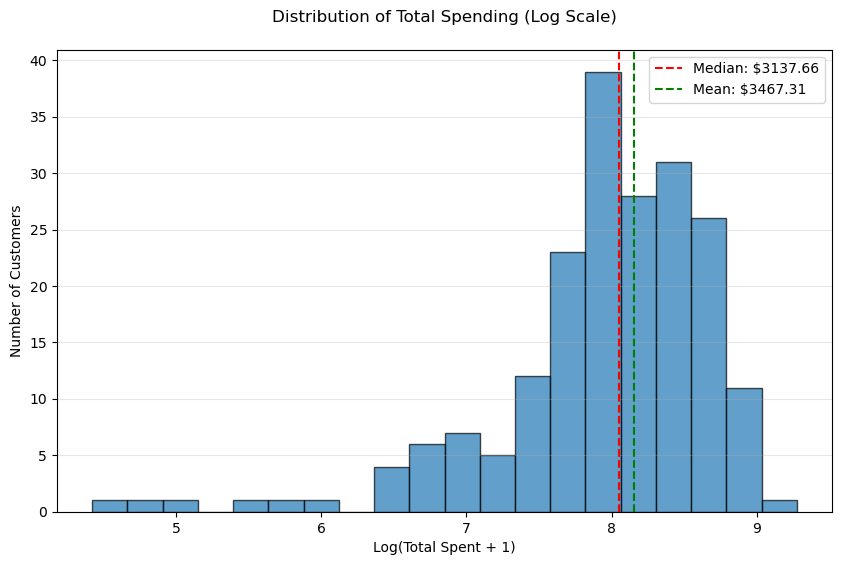

In [64]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Log scale if data is right-skewed (common for spending)
plt.hist(np.log1p(customer_features['total_spent']), bins=20, 
         edgecolor='black', alpha=0.7)
plt.title("Distribution of Total Spending (Log Scale)", pad=20)
plt.xlabel("Log(Total Spent + 1)")
plt.ylabel("Number of Customers")

# Add median/mean markers
median = np.log1p(customer_features['total_spent'].median())
mean = np.log1p(customer_features['total_spent'].mean())
plt.axvline(median, color='red', linestyle='--', label=f'Median: ${np.expm1(median):.2f}')
plt.axvline(mean, color='green', linestyle='--', label=f'Mean: ${np.expm1(mean):.2f}')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [40]:
print("\nMissing values check:")
print(customer_features.isnull().sum())


Missing values check:
total_spent                 0
avg_transaction             0
transaction_count           0
first_purchase              0
last_purchase               0
region                      0
signup_date                 0
days_since_signup           0
days_since_last_purchase    0
favorite_category           0
dtype: int64


In [42]:
print("\nCustomer Features Summary:")
print(customer_features.describe())


Customer Features Summary:
        total_spent  avg_transaction  transaction_count  \
count    199.000000       199.000000         199.000000   
mean    3467.314372       687.580182           5.025126   
min       82.360000        82.360000           1.000000   
25%     2162.040000       542.941667           3.000000   
50%     3137.660000       677.207500           5.000000   
75%     4770.225000       828.624167           6.000000   
max    10673.870000      1323.133333          11.000000   
std     1832.677958       237.936649           2.198340   

                      first_purchase                  last_purchase  \
count                            199                            199   
mean   2024-03-04 03:07:38.532663552  2024-10-15 01:17:23.909547520   
min              2023-12-30 15:29:12            2024-01-02 19:11:34   
25%       2024-01-17 15:36:12.500000     2024-09-15 00:45:57.500000   
50%              2024-02-12 03:10:36            2024-10-30 08:16:03   
75%           